# Init

In [1]:
from pyfiles import (
    complex as cplx,
    grid as grid,
    utils as utils,
    examples as ex,
    input as inp,
    plot as ourplot
)
from pyfiles.examples import CameraOpt

# so we don't have to reboot kernel every time we modify classes.py
%load_ext autoreload
%autoreload 2

import numpy as np
from typing import *
import matplotlib.pyplot as plt
%matplotlib inline
import mars

def export_obj(ex: ex.Example, complex: cplx.complex, faces: List[np.ndarray]):
    out_name = ex.filename.replace('input', 'output')
    name = out_name.split('/')[-1]
    name = name.split('.')[0]
    filename = f'output/{name}-GB{ex.grid_buffer}-GS{ex.grid_size}-MA{ex.medial_axis}'
    if ex.prune_eps is not None:
        filename += f'-peps{ex.prune_eps}'
    filename += '.obj'

    with open(filename, 'w') as f:
        vi = 1
        f.write(f'o {name}\n')
        for triangle in complex.trilist:
            a = triangle.coords[0]
            b = triangle.coords[1]
            c = triangle.coords[2]
            f.write(f'v {a[0]} {a[1]} {a[2]}\n')
            f.write(f'v {b[0]} {b[1]} {b[2]}\n')
            f.write(f'v {c[0]} {c[1]} {c[2]}\n')
            f.write(f'f {vi + 0} {vi + 1} {vi + 2}\n')
            vi += 3

        f.write(f'o {name}-MA{ex.medial_axis}\n')
        for [a, b, c, d] in faces:
            f.write(f'v {a[0]} {a[1]} {a[2]}\n')
            f.write(f'v {b[0]} {b[1]} {b[2]}\n')
            f.write(f'v {c[0]} {c[1]} {c[2]}\n')
            f.write(f'v {d[0]} {d[1]} {d[2]}\n')
            f.write(f'f {vi + 0} {vi + 1} {vi + 2} {vi + 3}\n')
            vi += 4
    print(f'Wrote {filename}')

def plotline(ax, p, q, *args, **kwargs):
    ax.plot([p[0], q[0]], [p[1], q[1]], [p[2], q[2]], *args, **kwargs)


# input

In [2]:
example = ex.ellipse2d_extrude_2

our_complex = inp.read_obj(example.filename)
gridd = grid.Grid3.from_complex(our_complex, example.grid_size, buffer=example.grid_buffer)

rs_complex = mars.read_from_obj(example.filename)

list_of_swaps = []
'''A list of swaps of the form `(old-cell, new-cell, [swaps])`'''

rs_states = {}
'''States for each point.  Used to live in the python Grid3'''

n_edges = gridd.number_of_grid_edges()
visit_count = 0
def visit(new_cell: Tuple[int,int,int], old_cell: Tuple[int,int,int]):
  global visit_count
  visit_count += 1
  perf = visit_count / n_edges * 100
  print(f'visiting {visit_count}/{n_edges} ({perf:.1f}%)\r', end='')
  if old_cell is None:
    center_point = gridd.coordinate(new_cell)
    with utils.Timed('rs reduce'):
      rs_states[new_cell] = mars.reduce_from_scratch(rs_complex, list(center_point))
  else:
    new_point = gridd.coordinate(new_cell)
    with utils.Timed('rs reduce_vine'):
      rs_old_state = rs_states[old_cell]
      (rs_new_state, swaps) = mars.vineyards_123(rs_complex, rs_old_state, list(new_point))
      list_of_swaps.append((old_cell, new_cell, swaps))
      rs_states[new_cell] = rs_new_state

with utils.Timed('flood_fill_visit'):
  gridd.flood_fill_visit(gridd.center_index(), visit)
utils.Timed.report()

|======== Timed report ========
| rs reduce       :     725.93ms  (725.928ms per; #1)
| rs reduce_vine  :     833.03ms  ( 0.301ms per; #2768)
| flood_fill_visit:    1573.83ms  (1573.833ms per; #1)
|==============================


# chop chop

Found 493 faces
Wrote output/ellipse2d-extrude-2-GB0.1-GS0.1-MA0.obj


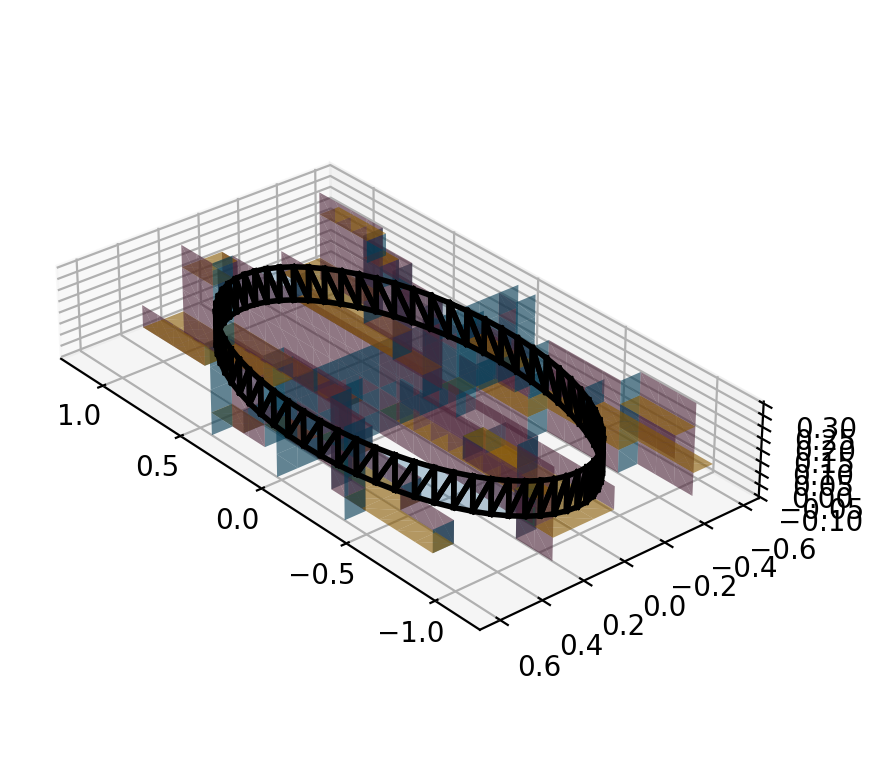

In [3]:
# CONTROL PARAMETERS
medaxdim = 1 # can say example.medial_axis when set

# euclidean prune: all dims
euclid_prune = False
prune_dist = 0.4

# coboundary: dim 0,2
cofaceprune = False

# faceprune: dim 1,2
faceprune = False

# persistence prune: dim 1
persprune = True
persistence_threshold = 0.01

###########################################

from dataclasses import dataclass
@dataclass
class Data:
  old_grid_point: List[float]
  new_grid_point: List[float]
  dim: int
  i: int
  j: int
  simplex_i_p: List[float]
  simplex_j_p: List[float]
  state_old: Any
  state_new: Any


faces = []
swap_coordinate_pairs = []
for (old_cell, new_cell, swaps) in list_of_swaps:
  state_old = rs_states[old_cell]
  state_new = rs_states[new_cell]
  swaps = swaps.pyclone()

  # PRUNING
  # coboundary: mainly for dim 0,2
  if cofaceprune:
    swaps.prune_coboundary(rs_complex)
  if faceprune:
    swaps.prune_common_face(rs_complex)

  # persistence: mainly for dim 1
  if persprune:
    swaps.prune_persistence(rs_complex, state_old, state_new, persistence_threshold)

  # euclidean prune: for all dims
  # NOTE: dist prune is NOT grid size based, it is absolute dist
  # if example.prune_dist is not None:
  #   swaps.prune_euclidian(rs_complex, example.prune_dist**2)
  if euclid_prune:
    swaps.prune_euclidian(rs_complex, prune_dist**2)
  # END PRUNING

  # CHOOSE MEDIAL AXIS HERE (`example.medial_axis`):
  swaps = list(filter(lambda t: t.dim == medaxdim, swaps.v))

  if 0 < len(swaps):
    faces.append(gridd.dual_face(old_cell, new_cell))
    s = swaps[0]
    swap_coordinate_pairs.append(Data(
      gridd.coordinate(old_cell),
      gridd.coordinate(new_cell),
      s.dim,
      s.i,
      s.j,
      rs_complex.simplices_per_dim[s.dim][s.i].center_point(rs_complex),
      rs_complex.simplices_per_dim[s.dim][s.j].center_point(rs_complex),
      state_old,
      state_new
    ))

print(f'Found {len(faces)} faces')
export_obj(example, our_complex, faces)
plt, ax = ourplot.plot_vineyard_results(
  our_complex,
  gridd,
  faces,
  CameraOpt(azim=140, elev=80),
  # only_edges=True,
  # complex_vertices=True,
  skip_grid=True,
  # skip_cube=True
)

# for d in swap_coordinate_pairs[i:i + 1]:
#   g1 = d.old_grid_point
#   g2 = d.new_grid_point
#   si_p = d.simplex_i_p
#   sj_p = d.simplex_j_p

#   killer_i = d.state_old.find_killer(d.dim, d.i)
#   victim_i = d.state_old.find_victim(d.dim, d.i)
#   if killer_i is not None:
#     kp = rs_complex.simplices_per_dim[d.dim+1][killer_i].center_point(rs_complex)
#     plotline(ax, si_p, kp, '-', color='red')
#   elif victim_i is not None:
#     vp = rs_complex.simplices_per_dim[d.dim-1][victim_i].center_point(rs_complex)
#     plotline(ax, si_p, vp, '-', color='green')
#   else:
#     print('no killer or victim for i')

#   killer_j = d.state_new.find_killer(d.dim, d.j)
#   victim_j = d.state_new.find_victim(d.dim, d.j)
#   if killer_j is not None:
#     kp = rs_complex.simplices_per_dim[d.dim+1][killer_j].center_point(rs_complex)
#     plotline(ax, sj_p, kp, '-', color='lightred')
#   elif victim_j is not None:
#     vp = rs_complex.simplices_per_dim[d.dim-1][victim_j].center_point(rs_complex)
#     plotline(ax, sj_p, vp, '-', color='lightgreen')
#   else:
#     print('no killer or victim for j')

#   plotline(ax, g1, si_p, '-', color='orange')
#   plotline(ax, g1, g2, '-', color='black')
#   plotline(ax, g2, sj_p, '-', color='yellow')



[-0.933268 -0.041634  0.05    ]


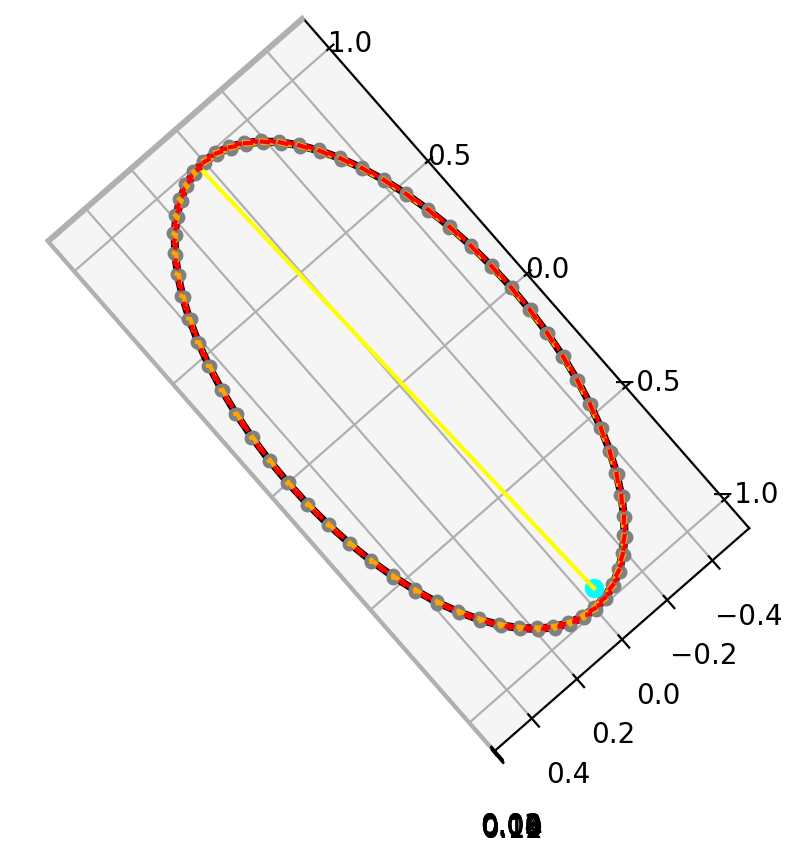

In [4]:
center = gridd.center_index()
# center = (center[0], 2, 1)
center = (1, center[1] - 1, 1)
p0 = gridd.coordinate(center)
print(p0)
scratch_state = rs_states[center]
plt, ax = ourplot.plot_vineyard_results(
  our_complex,
  gridd,
  [], #faces,
  CameraOpt(azim=140, elev=90),
  skip_grid=True,
  only_edges=True,
  complex_vertices=True,
)

ax.plot([p0[0]], [p0[1]], [p0[2]], 'o', color='cyan')

# killer of v7 is e0
# 

DIM = 1
# for kk in range(0, 10):
for kk in range(0, rs_complex.num_simplices_of_dim(DIM)):
  i = scratch_state.stacks[DIM].ordering.inv(kk)
  simp_point = rs_complex.simplices_per_dim[DIM][i].center_point(rs_complex)
  # plotline(ax, p0, simp_point, '-', color='blue')
  k = scratch_state.find_killer(DIM, i)
  v = scratch_state.find_victim(DIM, i)
  if k is not None:
    kp = rs_complex.simplices_per_dim[DIM+1][k].center_point(rs_complex)
    plotline(ax, simp_point, kp, '-', color='red')
  elif v is not None:
    vp = rs_complex.simplices_per_dim[DIM-1][v].center_point(rs_complex)
    plotline(ax, simp_point, vp, '-', color='orange')
  else:
    plotline(ax, simp_point, p0, '-', color='yellow')



In [5]:
scratch_state.betti_numbers()

[0, 1, 0]